In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import minimize
from datetime import datetime
import scipy.optimize
from sklearn.preprocessing import OrdinalEncoder
from sklearn import neighbors
from scipy.optimize import dual_annealing
from sklearn.metrics import confusion_matrix

In [2]:
# import Data

df = pd.read_csv('demandserver.csv')

## Identification Strategy
1. Price Elasticity

* Rider's price is different than base price (paid to drivers) due to tariff or subsidy.
* There are some exogenous variation in subsidy that could come from rounding.
* Two trips from A to B at the same day and hour could have same base price but different subsidy due to small difference in distance

    
2. Sensitivity to Waiting Time
* The average time takes to find a driver and pickup time at each location is endogenous but the deviation from that for each ride is exogenous.


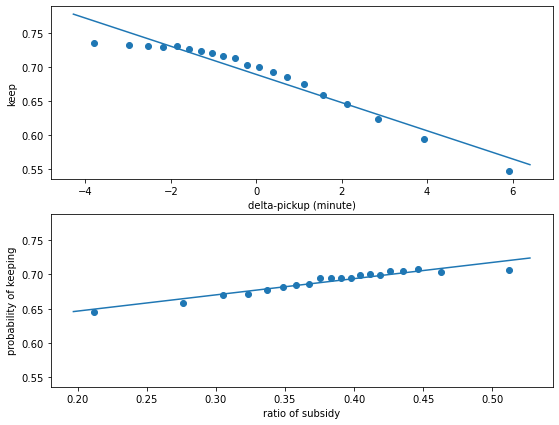

In [4]:
fig, axes = plt.subplots(2,  sharey=True, figsize=(9,7))
r =.1
s = df[df.r>r].reset_index(drop=True)
s.dropna(subset=['distance','baseprice','time3','r','avedtt', 'keep','dtt','peak'],inplace=True)
con = s[['distance','baseprice','time3','avedtt']].join(pd.get_dummies(s.w, prefix='w') )
con = con.join(pd.get_dummies(s.h, prefix='h') )

axes[0].binscatter(s['dtt'], s["keep"],
    controls=con, recenter_x=True, recenter_y=True) 
axes[0].set_xlabel('delta-pickup (minute)')

axes[1].binscatter(s['r'], s["keep"],
    controls=con, recenter_x=True, recenter_y=True)

axes[1].set_ylabel('probability of keeping')
axes[1].set_xlabel('ratio of subsidy')

del  s,con

## Model
Step One: requesting ride
* Rider who wants to go from A to B requests a ride if the utility from ride-hailing is higher than outside options (taxi, bus, or the rival app)
* Rider only observes the price at this step

Step Two: keeping the ride 
* Rider decides to cancel or not the ride after a driver found and pickup time shown to her


## Model-Step One: requesting ride
* Riders open the app and decide to request or not
* Riders are myopic and do not decide dynamically 
* Outside option is normalized to zero

$$
U_{i}=A(B_{i}, h_{i},  distance_{i} )+\alpha_{1} \, \text p_{i }+\alpha_{2} \, \bar{\omega_{i}}+\epsilon_{i, 1}
$$

$$
p_{i} = \bar{p_{i}} + m_{i}
$$
$$
U_{i}=V(B_{i}, h_{i},  \bar{p_{i}}) +\alpha_{1} \, \text m_{i }+\alpha_{2} \, \bar{\omega_{i}}+\epsilon_{i, 1} $$

$$
U_{i}\, =\pi_{i,1}+ \, \epsilon_{i, 1}
$$

$$
P_{\text {requesting ride}}= Pr\left(\epsilon_{i, 1}>-\pi_{i,1}\right) = (1- F_{\epsilon_{1}}\left(-\pi_{i,1}\right)) = R(\pi_{i,1})
$$




## Model-Step Two: keeping ride 
* Riders after observing the actual pickup time \( w\), decide to keep or cancel the ride.







$$
U_{i}= \pi_{i,1}+\alpha_{3} \Delta \omega + \epsilon_{i, 1}+ \epsilon_{i,2}
$$

$$
U_{i}=\pi_{i,2}+ \epsilon_{i, 1}+ \epsilon_{i,2}
$$

$$
P_{\text {keeping ride} \, \& \, \text{requesting ride}}=Pr\left((\epsilon_{i, 1}+ \epsilon_{i,2}>-\pi_{i,2}) \, \& \, (\epsilon_{i, 1}>-\pi_{i,1}) \right) 
$$
$$
P_{\text {keeping ride} \, \& \, \text{requesting ride}}= \int_{-\pi_{i,1}} f_{\epsilon_{1}}\left(\epsilon_{j}\right) \, (1- F_{\epsilon_{2}}\left(-\pi_{i,2}-\epsilon_{j,1}\right)) \, d\epsilon_{j}
$$
$$
P_{\text {keeping ride} \, \& \, \text{requesting ride}}= g(\pi_{1}, \alpha_{3} \Delta \omega, \sigma_{2})
$$

## Conditional Likelihood
* Conditional probability: probability of keeping conditional on requested

$$
\begin{array}{c}
f =\frac{g(\pi_{1}, \alpha_{3} \Delta \omega, \sigma_{2})}{R(\pi_{1})}  \\
\end{array}
$$


* Goal
 * Can I have a consistent estimate of true parameters?
 * Using Conditional likelihood and sample of a month of rides requested


In [ ]:
# Training the simulation of integral

x = np.round(np.arange(-8,6,.05), 2)
y = np.random.uniform(0,1,100000)
prob = pd.DataFrame(columns=['Uu1','prob_keep','dtt','fn','sigma', 'meany'])
dtt = np.round(np.arange(-4,4,.1), 2)
sigma = np.round(np.arange(.2,2,.2), 2)
for s in sigma:
    for f in dtt:
        for t in x:
            y2 = (1 - y) *norm.cdf(-t) + y
            y2 = ndtri(y2)
            a = 1 - norm.cdf((-y2-t-f)/s)
            prob=prob.append({'Uu1':t, 'prob_keep': np.mean(a), 'dtt':f, 'fn':len(y2), 'sigma':s,
                                 'meany':np.mean(y2)}, ignore_index=True)


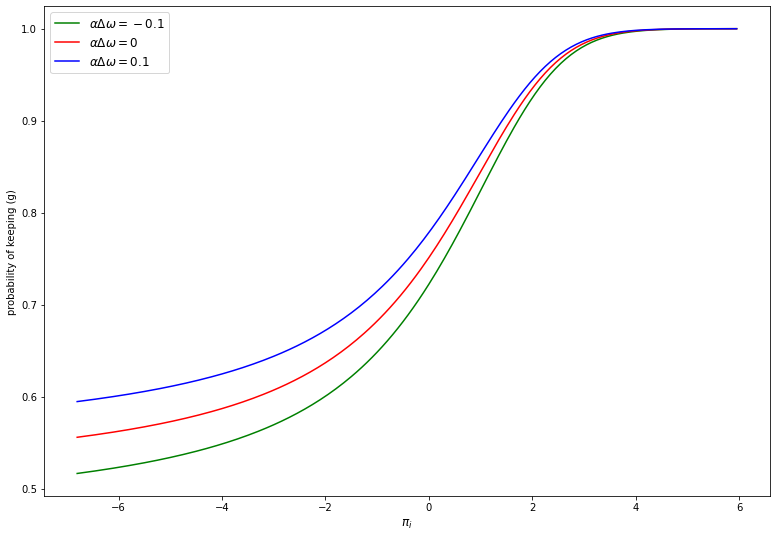

In [34]:

fig, axes = plt.subplots(1, sharex=True, sharey=True, figsize=(13,9))

for color, dtt in zip(['g','r','b'], [-.1, 0, .1]):

    s = prob[(prob.dtt==dtt) & (prob.sigma==1)]
    axes.plot(s.Uu1, s.prob_keep, c=color, label=r'$\alpha\Delta\omega={}$'.format(dtt))
                                                            
axes.set_ylabel('probability of keeping (g)')
axes.set_xlabel(r'$\pi_{i}$',fontsize='large')
plt.legend(fontsize='large')
plt.show()
del s